In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import pandas as pd

from ctgan.synthesizers import CTGAN, TVAE

from sdv.evaluation import evaluate

In [2]:
class BenchmarkMLP(nn.Module):
    def __init__(self, input_dim=784, output_dim=10) -> None:
        super(BenchmarkMLP, self).__init__()
        num_layers = 1
        layer_dim = (100,)
        self.layers = []
        dim = input_dim
        for i in range(num_layers):
            self.layers.append(
                nn.Linear(dim, layer_dim[i])
            )
            self.layers.append(nn.ReLU())
            dim = layer_dim[i]
        self.layers.append(
            nn.Linear(dim, output_dim)
        )
        self.layers = nn.ModuleList(self.layers)
        self.layers.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)


    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        out = torch.squeeze(x, -1)
        return out

In [3]:
def train_model(
    train_X,
    train_y,
    valid_X,
    valid_y,
    test_X,
    test_y,
    input_dim=784,
    output_dim=10,
    num_epochs=10,
    batch_size=64,
    device="cuda",
    model_type="classification",
    verbose=True
):
    # Training
    train_len = train_X.shape[0]
    num_batches_per_epoch = train_len // batch_size
    if train_len % batch_size != 0:
        num_batches_per_epoch += 1
    if model_type == "classification":
        critetion = nn.CrossEntropyLoss()
    elif model_type == "regression":
        critetion = nn.MSELoss()
    else:
        print("Invalid model_type argument")
        return

    model = BenchmarkMLP(input_dim=input_dim, output_dim=output_dim).to(device)
    optimizer = optim.Adam(model.parameters())

    train_X = torch.Tensor(train_X).to(device)
    train_y = torch.Tensor(train_y).to(device)
    valid_X = torch.Tensor(valid_X).to(device)
    valid_y = torch.Tensor(valid_y).to(device)
    test_X = torch.Tensor(test_X).to(device)
    test_y = torch.Tensor(test_y).to(device)

    best_valid_score = -float("inf")
    best_model_weights = model.state_dict()
    for epoch in tqdm(range(num_epochs)):
        model.train()
        idx = 0
        epoch_loss = 0
        for _ in range(num_batches_per_epoch):
            input = train_X[idx : idx + batch_size]
            targets = train_y[idx : idx + batch_size]
            idx += batch_size
            output = model(input)
            loss = critetion(output, targets)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = epoch_loss / train_len

        model.eval()
        with torch.no_grad():
            output = model(valid_X)
            valid_loss = critetion(output, valid_y) / valid_y.shape[0]
            output = torch.argmax(output, -1)
            valid_score = f1_score(output.cpu(), valid_y.argmax(-1).cpu(), average="macro")
            if valid_score > best_valid_score:
                best_valid_score = valid_score
                best_model_weights = model.state_dict()

        if verbose or epoch % 25 == 0:
            print(f"Epoch: {epoch + 1}, Training Loss: {epoch_loss:.4f}, Valid Loss: {valid_loss:.8f}, Valid score: {valid_score:.4f}")

    print(f"Best validation score: {best_valid_score}")
    model.load_state_dict(best_model_weights)
    model.eval()
    with torch.no_grad():
        output = model(test_X)
        valid_loss = critetion(output, test_y) / test_y.shape[0]
        output = torch.argmax(output, -1)
        test_score = f1_score(output.cpu(), test_y.argmax(-1).cpu(), average="macro")
    
    return test_score

In [4]:
"""https://mattpetersen.github.io/load-mnist-with-numpy"""
"""Load from /home/USER/data/mnist or elsewhere; download if missing."""

import gzip
import os
from urllib.request import urlretrieve
import numpy as np


def load_mnist(path="dataset/mnist/"):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        # return pixels.reshape(-1, 784).astype('float32') / 255
        return (pixels.reshape(-1, 784) != 0).astype(np.int8)

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=1, shuffle=True, stratify=train_labels.argmax(-1))

    return train_images, train_labels, valid_images, valid_labels, test_images, test_labels

In [5]:
def load_credit(path="dataset/credit/"):
    credit_df = pd.read_csv(f"{path}creditcard.csv")
    credit_train_y = credit_df.pop("Class").to_numpy()
    credit_train_y = np.eye(2)[credit_train_y]
    credit_train_X = credit_df.to_numpy()
    credit_train_X, credit_test_X, credit_train_y, credit_test_y = train_test_split(credit_train_X, credit_train_y, test_size=20000, random_state=1, shuffle=True, stratify=credit_train_y)
    credit_train_X, credit_valid_X, credit_train_y, credit_valid_y = train_test_split(credit_train_X, credit_train_y, test_size=10000, random_state=1, shuffle=True, stratify=credit_train_y)

    return credit_train_X, credit_train_y, credit_valid_X, credit_valid_y, credit_test_X, credit_test_y

In [4]:
def load_adult(path="dataset/adult/"):
    adult_train_df = pd.read_csv(f"{path}adult.data", header=None)
    adult_test_df = pd.read_csv(f"{path}adult.test", header=None)
    columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income_50k"]
    cat_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income_50k"]
    adult_train_df.columns = columns
    adult_test_df.columns = columns
    adult_train_df = pd.get_dummies(adult_train_df, cat_columns)
    adult_test_df = pd.get_dummies(adult_test_df, cat_columns)
    # Remove extra . at the end in the test set
    adult_test_df["income_50k_ >50K"] = adult_test_df.pop("income_50k_ >50K.")
    adult_test_df["income_50k_ <=50K"] = adult_test_df.pop("income_50k_ <=50K.")
    # Add missing columns in test
    missing_columns = list(set(adult_train_df.columns) - set(adult_test_df.columns))
    for col_name in missing_columns:
        adult_test_df[col_name] = 0
    # Sort columns to ensure same ordering in train and test data frames
    adult_train_df = adult_train_df.reindex(sorted(adult_train_df.columns), axis=1)
    adult_test_df = adult_test_df.reindex(sorted(adult_train_df.columns), axis=1)
    adult_train_y = adult_train_df[["income_50k_ >50K", "income_50k_ <=50K"]].to_numpy()
    adult_train_X = adult_train_df.drop(["income_50k_ >50K", "income_50k_ <=50K"], axis=1).to_numpy()
    adult_test_y = adult_test_df[["income_50k_ >50K", "income_50k_ <=50K"]].to_numpy()
    adult_test_X = adult_test_df.drop(["income_50k_ >50K", "income_50k_ <=50K"], axis=1).to_numpy()
    adult_train_X, adult_valid_X, adult_train_y, adult_valid_y = train_test_split(adult_train_X, adult_train_y, test_size=0.1, random_state=1, shuffle=True, stratify=adult_train_y.argmax(-1))

    return adult_train_X, adult_train_y, adult_valid_X, adult_valid_y, adult_test_X, adult_test_y 

In [7]:
train_images, train_labels, valid_images, valid_labels, test_images, test_labels = load_mnist("../dataset/mnist/")

test_score = train_model(
    train_images,
    train_labels,
    valid_images,
    valid_labels,
    test_images,
    test_labels,
    input_dim=784,
    output_dim=10,
    batch_size=64,
    num_epochs=10,
    model_type="classification"
)
print(f"Test score: {test_score}")

In [8]:
credit_train_X, credit_train_y, credit_valid_X, credit_valid_y, credit_test_X, credit_test_y = load_credit("../dataset/credit/")

test_score = train_model(
    credit_train_X,
    credit_train_y,
    credit_valid_X,
    credit_valid_y,
    credit_test_X,
    credit_test_y,
    input_dim=30,
    output_dim=2,
    batch_size=256,
    num_epochs=20,
    model_type="classification"
)
print(f"Test score: {test_score}")

In [5]:
adult_train_X, adult_train_y, adult_valid_X, adult_valid_y, adult_test_X, adult_test_y = load_adult("../dataset/adult/")

In [7]:
test_score = train_model(
    adult_train_X,
    adult_train_y,
    adult_valid_X,
    adult_valid_y,
    adult_test_X,
    adult_test_y,
    input_dim=108,
    output_dim=2,
    batch_size=128,
    num_epochs=50,
    model_type="classification",
    verbose=False,
)
print(f"Test score: {test_score}")

  2%|▏         | 1/50 [00:00<00:18,  2.68it/s]

Epoch: 1, Training Loss: 2.0450, Valid Loss: 0.02973681, Valid score: 0.5840


 54%|█████▍    | 27/50 [00:06<00:04,  5.17it/s]

Epoch: 26, Training Loss: 0.7123, Valid Loss: 0.05727495, Valid score: 0.5778


100%|██████████| 50/50 [00:12<00:00,  3.91it/s]

Best validation score: 0.7439652108131756
Test score: 0.6718911207600942


#### Best test (real data) F1 macro score for real adult train data is: 0.75

### MNIST

### CTGAN

train_data = np.concatenate((train_images, train_labels.argmax(-1)[:,None]), axis=1)
valid_data = np.concatenate((valid_images, valid_labels.argmax(-1)[:,None]), axis=1)
data = np.concatenate((train_data, valid_data), axis=0)

ctgan = CTGAN(batch_size=10**3, verbose=True)
ctgan.fit(data, discrete_columns=list(range(data.shape[1])), epochs=30)

fake = ctgan.sample(1)
plt.imshow(fake[0][:-1].reshape(28, 28), cmap="gray")
print(fake[0][-1])

### TVAE

tvae = TVAE(batch_size=10**3, epochs=30)
tvae.fit(data, discrete_columns=list(range(data.shape[1])))

fake = tvae.sample(1)
plt.imshow(fake[0][:-1].reshape(28, 28), cmap="gray")
print(fake[0][-1])

## Adult dataset

#### CTGAN

In [8]:
path = "../dataset/adult/"
adult_train_df = pd.read_csv(f"{path}adult.data", header=None)
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income_50k"]
cat_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income_50k"]
adult_train_df.columns = columns

In [11]:
results = dict()
for num_epoch in (30, 50, 75, 100, 200):
    ctgan = CTGAN()
    ctgan.fit(adult_train_df, discrete_columns=cat_columns, epochs=num_epoch)
    fake_df = ctgan.sample(adult_train_df.shape[0])
    score = evaluate(fake_df, adult_train_df)
    print(f"Num epochs: {num_epoch}")
    print(f"Evaluation score: {score}")
    results[num_epoch] = score

100%|██████████| 30/30 [01:08<00:00,  2.29s/it]


Num epochs: 30
Evaluation score: 0.8683458676625677


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


Num epochs: 50
Evaluation score: 0.8985942118533576


100%|██████████| 75/75 [02:49<00:00,  2.26s/it]


Num epochs: 75
Evaluation score: 0.8975955007394705


100%|██████████| 100/100 [03:46<00:00,  2.27s/it]


Num epochs: 100
Evaluation score: 0.8829438181106639


100%|██████████| 200/200 [07:59<00:00,  2.40s/it]


Num epochs: 200
Evaluation score: 0.8892081062754086


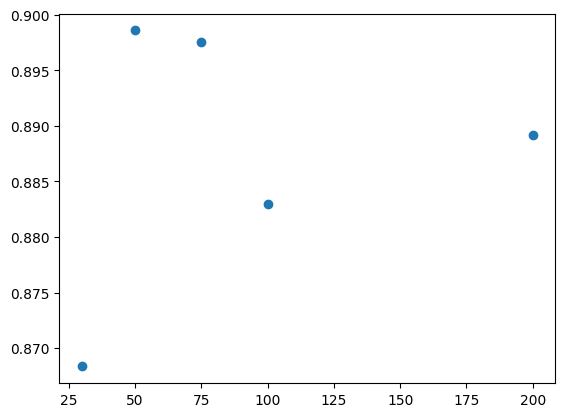

In [12]:
plt.scatter(x=results.keys(), y=results.values())

##### 50 epochs gives the best result

In [9]:
ctgan = CTGAN()
ctgan.fit(adult_train_df, discrete_columns=cat_columns, epochs=50)
fake_df = ctgan.sample(adult_train_df.shape[0])
score = evaluate(fake_df, adult_train_df)
print(f"Evaluation score: {score}")

In [36]:
fake_df_ctgan = ctgan.sample(adult_train_df.shape[0])

### TVAE

In [ ]:
vae_results = dict()
for num_epoch in (10, 30, 50, 75, 100):
    done = 0
    while(not done):
        tvae = TVAE(epochs=num_epoch)
        tvae.fit(adult_train_df, discrete_columns=cat_columns)
        try:
            fake_df = tvae.sample(adult_train_df.shape[0])
            done = 1
        except:
            # Some times decoder weights are trained to be nan! In that case re-train
            print("retrying")
    score = evaluate(fake_df, adult_train_df)
    print(f"Num epochs: {num_epoch}")
    print(f"Evaluation score: {score}")
    vae_results[num_epoch] = score

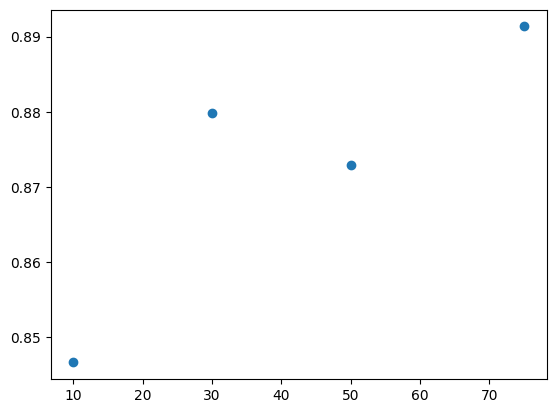

In [27]:
# VAE is unable to train for >= 100 epochs
vae_results
plt.scatter(x=vae_results.keys(), y=vae_results.values())

### Use 50 epochs for VAE as well

In [15]:
tvae = TVAE(epochs=50)
tvae.fit(adult_train_df, discrete_columns=cat_columns)
fake_df_vae = tvae.sample(adult_train_df.shape[0])
score = evaluate(fake_df_vae, adult_train_df)
print(f"Num epochs: {num_epoch}")
print(f"Evaluation score: {score}")

100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


Num epochs: 200
Evaluation score: 0.8885616765777864


In [31]:
fake_df_vae = tvae.sample(adult_train_df.shape[0])

### ML efficacy of CTGAN/TVAE on Adult dataset

In [37]:
fake_df_ctgan = pd.get_dummies(fake_df_ctgan, cat_columns)
adult_train_df = pd.get_dummies(adult_train_df, cat_columns)
# Add missing columns in test
missing_columns = list(set(adult_train_df.columns) - set(fake_df_ctgan.columns))
for col_name in missing_columns:
    fake_df_ctgan[col_name] = 0
# Sort columns to ensure same ordering in train and test data frames
fake_df_ctgan = fake_df_ctgan.reindex(sorted(adult_train_df.columns), axis=1)
adult_fake_train_X = fake_df_ctgan.drop(["income_50k_ >50K", "income_50k_ <=50K"], axis=1).to_numpy()
adult_fake_train_y = fake_df_ctgan[["income_50k_ >50K", "income_50k_ <=50K"]].to_numpy()
adult_fake_train_X, adult_fake_valid_X, adult_fake_train_y, adult_fake_valid_y = train_test_split(
    adult_fake_train_X, adult_fake_train_y, test_size=0.1, random_state=1, shuffle=True, stratify=adult_fake_train_y.argmax(-1)
)

In [57]:
test_score = train_model(
    adult_fake_train_X,
    adult_fake_train_y,
    adult_fake_valid_X,
    adult_fake_valid_y,
    adult_test_X,
    adult_test_y,
    input_dim=108,
    output_dim=2,
    batch_size=128,
    num_epochs=50,
    model_type="classification",
    verbose=False,
)
print(f"Test score: {test_score}")

  2%|▏         | 1/50 [00:00<00:13,  3.57it/s]

Epoch: 1, Training Loss: 0.7726, Valid Loss: 0.01061454, Valid score: 0.2408


 52%|█████▏    | 26/50 [00:06<00:06,  3.95it/s]

Epoch: 26, Training Loss: 0.2558, Valid Loss: 0.03209069, Valid score: 0.4322


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]

Best validation score: 0.740550564726675
Test score: 0.6672773629137057


#### Best test (real data) F1 macro score for fake adult CTGAN train data is: 0.70